In [1]:
__author__ = 'Matthew Manley'
#
import numpy as np               # Numpy library
from PIL import Image as im      # Basic image processing library 

### Line (ray) equation 

The ray equation is given by:

$$
\begin{align}
    {\bf p}\left(t\right) = {\bf e} + {\bf d} t,
\end{align}
$$
where: 
$$
\begin{align}
    {\bf d}  = {\bf s} - {\bf e}.
\end{align}
$$


![](ray.jpg)

The diagram shows the main components of the 3-D scene (and virtual camera), i.e.: 

- ${\bf e} \in \mathbb{R}^3$ is the eye location (i.e., viewer)

- ${\bf s} \in \mathbb{R}^3$ is a point on the image plane

- ${\bf d} \in \mathbb{R}^3$ is the ray direction

- $f \in \mathbb{R}$ is the focal distance (i.e., perpendicular distance between the center of projection and the image plane. 




In [2]:
class Ray:
    """A class representing a ray (line in space). 
    
    Uses the parametric representation of a line, p(t) = e + (s - e)*t.
    
    The ray passes through the following two points: 

    e = [e_u, e_v, e_w] representing the eye location in 3-D, and      
    s = [e_u, e_v, e_w] representing a point on the image plane.

    Attributes:
        e: 3x1 np.array, e.g., 
        s: 3x1 np.array 
    """

    def __init__(self, e, s):
        """Constructor method

        Args:
            e (3x1 np.array): Eye location
            s (3x1 np.array): Point on the image plane
        """
        self.e = e   
        self.s = s   


    def get3DPoint(self, t):        
        """Calculates the location of a 3-D point along the ray given t.

        Args:
            t (float): Parameter of the ray equation
        Returns:
            p (3x1 nd.array): Point p(t) = e + (s - e) * t.
        """
        p = self.e + (self.s - self.e) * t    # p(t) = e + (s - e) * t
        
        return p
    

### Sphere equation 

The sphere equation in vector form is given by:

$$
\begin{align}
    \left({\bf p} - {\bf c}\right)\cdot \left({\bf p} - {\bf c}\right) - r^2 = 0,
\end{align}
$$

where ${\bf c} \in \mathbb{R}^3$ is the center of the sphere. 

#### Ray-sphere intersection
First, we substitute the ray equation into the sphere equation, i.e.: 

$$
\begin{align}
    \left({\bf e} + {\bf d}\,t - {\bf c}\right)\cdot \left({\bf e} + {\bf d}\,t - {\bf c}\right) - r^2 = 0. 
\end{align}
$$

Then, we expand the dot product (similarly to using the distributive property in multiplication) and re-arrange the terms to obtain: 

$$
\begin{align}
    \underbrace{\left({\bf d}\cdot {\bf d}\right)}_{A}t^2 + \underbrace{2\,{\bf d}\cdot\left({\bf e} - {\bf c}\right)}_{B}\,t + \underbrace{\left({\bf e} - {\bf c}\right) \cdot \left({\bf e} - {\bf c}\right) - r^2}_{C} = 0, 
\end{align}
$$

which is the classic quadratic equation: 

$$
\begin{align}
    {A}t^2 + {B}\,t + {C} = 0. 
\end{align}
$$

Its solution for t is given by: 

$$
\begin{align}
    t = \frac{-B\pm\sqrt{B^2-4AC}}{2A}. 
\end{align}
$$







In [3]:
class Sphere:
    """A class representing a Sphere.

    Attributes:
        Center (3x1 np.ndarray): Center of the sphere in 3-D
        Radius (float): Radius of the sphere
        Color (3x1 np.ndarray): (Solid) Color of the sphere's surface Color = [ red, green, blue]
    """
    
    def __init__(self, c, r, k):
        """Constructor method

        Args:
            c (3x1 np.ndarray): Center 
            r (float): Radius
            k (3x1 np.ndarray): Color [red, green, blue], each component is in the [0,255] range            
        """
        self.Center = c
        self.Radius = r
        self.Color = k

    def Intersect(self, ray):
        """Calculates the intersection of this sphere and the ray provided as input

        Args:
            ray (Ray object)  p(t) = e + (s - e) * t
        Returns:
            t (float): distance (line parameter) from the eye to the intersection point along the ray
        """
        # ray: ray object  p(t) = e + (s - e) * t

        # For calculations, I prefer to use the notation
        # similar to the one in the slides or associated paper.
        d = ray.s - ray.e  # Direction of the ray
        e = ray.e          # Ray's starting point

        c = self.Center  # Sphere center
        r = self.Radius  # Sphere radius

        # Check whether the ray intersects the sphere
        A = np.dot(d, d)
        B = 2.0 * np.dot(d, (e - c))
        C = np.dot((e - c), (e - c)) - r * r

        #delta = B*B - A * C
        delta = B*B - 4.0 * A * C
        if delta < 0:
            return float("inf")         # Ray didn't intersect sphere
        else:
            # Compute value of parameter t at the intersection point
            t1 = (-B - np.sqrt(delta)) / (2.0 * A)
            t2 = (-B + np.sqrt(delta)) / (2.0 * A)

            # We are interested only in the closest intersection.
            # We take the smaller t
            t = np.min([t1, t2])
            
            return t
        
    def get_normal(self, p):
        """ Calculates the surface normal at the point p on the sphere. 
            It assumes that p is on the sphere!!!
        Args:
            p (3x1 np.ndarray): 3-D point on the sphere 
        Returns:
            n (3x1 np.ndarray): Normalized (unit) normal vector at point p
        """
        
        n = (p - self.Center) / np.linalg.norm(p - self.Center)
        
        return n
        

### Converting between image-plane coordinates and image-matrix indices

When creating the rays we need to take into account that the coordinates (i.e., indices) of the image matrix are $(i,j)$ and the coordinates of the image plane are $(u,v)$.  

We also need to remember that the origin of the $(u,v)$-system is at the center of the plane while the origin of the image matrix is (usually) at the top-left corner. 

As a result, we must convert between geometric $(u,v)$ coordinates and matrix indices $(i,j)$. 

![](uv_ij.jpg)



In [4]:
class Camera:
    """A class representing the camera.
    
    This camera consists of the focal length, the image matrix, and functions 
    that convert pixel coordinates to geometric (u,v,w)-coordinates. 

    Attributes:
        f (float): Camera's focal distance
        
        nrows (int): Image horizontal resolution in pixels 
        ncols (int): Image vertical resolution in pixels 
        I (np.ndarray of size nrows x ncols)
    """
    # Number of color channels
    nchannels = 3    # channels (RGB)
    
    # Eye location (i.e., viewer)
    eye = np.array((0.0, 0.0, 0.0)).transpose()

    
    def __init__(self, f, nrows, ncols):
        # f: Focal distance 
        self.f = f         
        self.nrows = nrows    # Image resolution in pixels 
        self.ncols = ncols

        # Initialize image matrix 
        self.I = np.zeros([self.nrows, self.ncols, self.nchannels])

    'Convert pixel coordinates to geometric coordinates'
    def ij2uv(self, i, j):
        u =  (j + 0.5) - self.ncols/2 
        v = -(i + 0.5) + self.nrows/2
        
        return u,v

    def constructRayThroughPixel(self, i, j):
        # Construct ray through pixel (i,j)
        u,v = self.ij2uv(i, j)
        s = np.array((u, v, -self.f)).transpose()
        ray = Ray(self.eye, s)                        

        return ray
    


In [5]:
class HitInformation:
    """A class representing the all the information of objects intersected by a given ray.

    Attributes:
        Object (python class of object): e.g., sphere, cylinder, cone, plane
        
        p (3x1 np.ndarray): 3-D coordinates of the intersection point 
    """
    def __init__(self, intersected_object, intersecton_point):
        self.Object = intersected_object
        self.p = intersecton_point
        
     

In [6]:
class Scene: 
    """A class representing the whole scene, i.e., objects in the scene.

    I wanted Scene to consist of the entire scene that consists of 
    all objects (e.g., spheres, planes, triangles, cilinders). 
    
    Here is just a preliminary attempt of implementing a list of objects.         

    Attributes:
        Object (python class of object): e.g., sphere, cylinder, cone, plane
        
        p (3x1 np.ndarray): 3-D coordinates of the intersection point 
    """
    
    light_source_1 = np.array([200,500,200])
    light_source_1 = light_source_1 / np.linalg.norm(light_source_1)
    
    
    def __init__(self, theCamera):
        
        self.theCamera = theCamera   # I think I need the camera because it has the eye location 
        
        # I simply implement this class as a list of geometrical objects. 
        list = []
        
        # Object 1
        Center = np.array((-90, 0, -400.0)).transpose()
        Radius = 80.0
        Color = np.array((255, 0, 0)).transpose()        
        list.append(Sphere(Center, Radius, Color))
        
        # Object 2
        Center = np.array((90, 0, -400.0)).transpose()
        Radius = 80.0
        Color = np.array((0, 255, 0)).transpose()                    
        list.append(Sphere(Center, Radius, Color))
        
        
        # Object 3 (the plane)
        p1 = np.array((0.0,0.0,-500.0))
        n = np.array((0.0,0.0,1.0))
        Color = np.array((0, 0, 255)).transpose() 
        list.append(Plane(p1, n, Color))

        # List of objects in the scene 
        self.scene_objects = list
           
    def find_intersection(self, ray):
        """Intersects the ray with the scene (all objects in the scene)

        Args:
            ray (Ray object)  p(t) = e + (s - e) * t
        Returns:
            hit (python list): list with the information about the hits.
        """
        hit_list = []        # List of intersections (location and object intersected)
        for surface in self.scene_objects: 
            t = surface.Intersect(ray)                  # t parameter at intersection point
            if float('inf') != t:                       # Does the ray intersects the surface? 
                p = ray.get3DPoint(t)                   # (u,v,w) coordinates of intersection point
                hitInfo = HitInformation(surface, p)
                hit_list.append(hitInfo)                     # We might need more attributes...

        return hit_list     # List with the information about the hits

    def get_color(self, hit_list):  
        """Returns the `seen' by the visual ray. This is the sum of all colors * shading 
        """
        pixelColor =  np.array((0.0, 0.0, 0.0))  # Initial color is black               
        
        if len(hit_list) == 0:
            return pixelColor
        
        min_p = np.linalg.norm(hit_list[0].p)
        for hit in hit_list:
            if min_p > np.linalg.norm(hit.p):
                min_p = np.linalg.norm(hit.p)
        
        
        for hit in hit_list:                    # Loop through hits             
            if np.linalg.norm(hit.p) == min_p:
                # Get surface normal at the intersection point
                n = hit.Object.get_normal(hit.p)
                # Calculate diffuse shading 
                diffuse_shading = max(0, np.dot(n, self.light_source_1)) * 0.33
            
                # Ambient light component
                ambient_color = hit.Object.Color * 0.3 
            
                # Calculate specular component 
                v = self.theCamera.eye - hit.p
                if (np.linalg.norm(v) > 0):
                    v = v / np.linalg.norm(v)
                h = v + self.light_source_1
                h = h / np.linalg.norm(h)
            
                specular_component = max(0, np.dot(n, h)) ** 64
                specular_component = specular_component * 0.33
                #specular_component = 0


                pixelColor += ambient_color + hit.Object.Color * diffuse_shading + hit.Object.Color * specular_component# Color of the intersected object (at the intersection point)  
         
                # Each color component is in the range [0..255]. 
                #pixelColor =  pixelColor / len(self.scene_objects)
            
                if (pixelColor[0] > 255):
                    pixelColor[0] = 255
            
                if (pixelColor[1] > 255):
                    pixelColor[1] = 255
                
                if (pixelColor[2] > 255):
                    pixelColor[2] = 255
                #np.linalg.norm(pixelColor)
            
        
        return pixelColor 
    

### The plane equation 
The plane through ${\bf p}_1 = \left(u,v,w\right)^\mathsf{T}$, with surface normal ${\bf n} = \left(n_u,n_v,n_w\right)^\mathsf{T}$ is given by the following implicit equation: 

$$
\begin{align}
    \left({\bf p} - {\bf p}_1\right) \cdot {\bf n} = 0.
\end{align}
$$

#### Ray-plane intersection

The equation of the ray (line) between the eye and a point on the image plane is given by: 

$$
\begin{align}
    {\bf p}\left(t\right) = {\bf e} + {\bf d} t,
\end{align}
$$

where: 

$$
\begin{align}
    {\bf d}  = {\bf s} - {\bf e}.
\end{align}
$$

The intersection between the ray and a plane is the point ${\bf p}\left(t\right)$ for: 

$$
\begin{align}
    t = \frac{({\bf p}_1 - {\bf e}) \cdot {\bf n}}{{\bf d} \cdot {\bf n}}.
\end{align}
$$




### Calculating the (unit) normal vector of a plane 

Select three non-colinear points, use these points to create two vectors on the plane, then calculate their cross product. Normalize the result to obtain the (unit) normal vector. 

![](./trinormal.jpg)

(Unit) normal vector to the plane: 

$$
{\bf n} = \frac{({\bf b} - {\bf a}) \,\times ({\bf c} - {\bf a})}
{\|({\bf b} - {\bf a}) \,\times ({\bf c} - {\bf a})\|} 
$$

### Diffuse shading

$$
    \text{shaded_color} = (r,g,b) * max(0, l \cdot n ) 
$$

In [7]:
class Plane:
    """A class representing a plane. 

    The components of the plane equation are: 
    
    - A point on the plane
    - The planes normal vector (i.e., a normalized vector perpendicular to the plane)
    - The color (flat/solid) of the plane (RGB)

    Attributes:
        p1 (3x1 np.ndarray): any point on the plane        
        n (3x1 np.ndarray): the normalized vector that perpendicular to the plane
        Color (3x1 np.ndarray): the plane's color
    """
    def __init__(self, p1, n, k):
        """Constructor method

        Args:
            p1 (3x1 np.ndarray): Point on the plane 
            n (3x1 np.ndarray): Plane's normal vector
            k (3x1 np.ndarray): Color [red, green, blue], each component is in the [0,255] range            
        """
        self.p1    = p1
        self.n     = n 
        self.Color = k

    def Intersect(self, ray):
        """Calculates the intersection of this plane and the ray provided as input

        Args:
            ray (Ray object)  p(t) = e + (s - e) * t
        Returns:
            t (float): distance (line parameter) from the eye to the intersection point along the ray
        """
        
        d = ray.s - ray.e #direction of ray
        e = ray.e #starting point
        
        t = np.dot((self.p1 - e), self.n) / np.dot(d, self.n)
        
        if (t< 0):
            return float("inf")
        
        #pass
            
        return t        
    
    def get_normal(self, p):
        """ Calculates the surface normal at the point p on the sphere. 
            It assumes that p is on the sphere!!!
        Args:
            p (3x1 np.ndarray): 3-D point on the sphere 
        Returns:
            n (3x1 np.ndarray): Normalized (unit) normal vector at point p
        """
        
        return self.n

### Basic ray-tracing/ray-casting algorithm

The basic algorithm for ray tracing is given by: 

![](./algorithm.jpg)

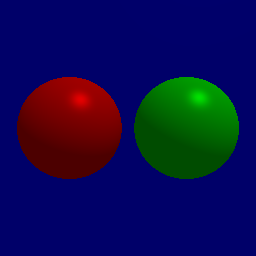

In [8]:
# Create camera (and image resolution)
nrows = 256
ncols = 256
# Focal distance
f = 250.0

myCamera = Camera(f, nrows, ncols)

# Create the scene (collection of objects - hardcoded for simplicity)
theScene = Scene(myCamera)

# Loop through all pixels (i,j) in the image matrix 
for i in range(nrows): 
    for j in range(ncols):
        # Construct the ray between between the eye and s = (u, v, -f)       
        ray = myCamera.constructRayThroughPixel(i, j)
        
        # Intersect the ray with the scene (all objects in the scene)
        hit = theScene.find_intersection(ray)   
                                                
        # Set the pixel color 
        myCamera.I[i,j,:] = theScene.get_color(hit)
       
        
# Create an image from an array (display image and save file)
out_image = im.fromarray(np.uint8(myCamera.I))
display(out_image)
out_image.save('raytraced_scene.png')

In [9]:
max(3.2,2.1)

3.2